# PRS-preselection-based trans QTL analysis

# Summary

This is a short summary of our polygenic risk score (PRS) based pathway enrichment approach to preselect candidate genes for trans QTL analyses.

You can find a preprint version of the manuscript  
Ines Assum & Julia Krause et al., Tissue-specific multiOMICs analysis of atrial fibrillation, *bioRxiv* (2020)  
here:
https://doi.org/10.1101/2020.04.06.021527

We address a key hypothesis about the existence of core genes as postulated in the omnigenic model by [Liu et al.](https://doi.org/10.1016/j.cell.2019.04.014), *Cell* (2019). Core genes are central genes with trans-associations to GWAS loci, whose expression levels directly affect a disease phenotype. Here we sought to identify candidate core genes for AF to understand the contribution of trans-genetic effects in the pathology of AF. To prioritize genes satisfying the properties predicted by the omnigenic model, we evaluated the accumulation of trans-effects, their relevance in gene regulatory networks, and the disease association by the following strategy:


i) Evaluate cumulated trans-effects of disease-associated variants on expression by ranking genes based on their correlation of mRNA and protein abundance with a PRS (eQTS) as proposed by [Võsa et al.](https://doi.org/10.1101/447367), *bioRxiv* (2018)

ii) Identify genes sharing molecular function and representing biological networks that propagate genetic trans-effects to core genes by pathway enrichment analysis (GSEA) on the eQTS rankings. Genes driving the enrichment of multiple gene sets were selected as core gene candidates.

iii) Establish the link between the core gene candidates and the disease based on a significant trans eQTL GWAS hit.

# Example

## Requirements

This tutorial uses the following packages:

* [fgsea](https://bioconductor.org/packages/release/bioc/html/fgsea.html)
* [MatrixEQTL](https://github.com/andreyshabalin/MatrixEQTL)
* [eQTLpipeline](https://github.com/matthiasheinig/eQTLpipeline)

and data

* [1k_genomes_PRS_expr.tsv](https://github.com/heiniglab/symatrial/blob/master/example_data/1k_genomes_PRS_expr.tsv)
* [1k_genomes_AF_snps.txt](https://github.com/heiniglab/symatrial/blob/master/example_data/1k_genomes_AF_snps.txt)
* [GO bp .gmt file](https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/7.1/c5.bp.v7.1.symbols.gmt).

Packages are installed in the first code chunk (running it might take up to 10 minutes). You can skip the first code chunk and only load the precomputed results, if you are in a hurry.

All necessary data is downloaded automatically, you only need to download gene set annotations for the GO biological processes ([GO bp .gmt file](https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/7.1/c5.bp.v7.1.symbols.gmt)).
To temporarily upload files to this runtime, click on the folder symbol on the top left. Using the panel that opens, you can choose "Upload" to open a window to browse your local file system.

In [0]:
#Install necessary libraries
install.packages(c("devtools","RColorBrewer"), dependencies = T, clean = T)
BiocManager::install("fgsea", dependencies = T, clean = T)

library(devtools)
devtools::install_github("andreyshabalin/MatrixEQTL", force=T)
devtools::install_github("matthiasheinig/eQTLpipeline", force=T)

#Load libraries
library(fgsea)
library(MatrixEQTL)
library(eQTLpipeline)

In [0]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] eQTLpipeline_0.1  BatchJobs_1.8     BBmisc_1.11       data.table_1.12.8
[5] MatrixEQTL_2.3    fgsea_1.12.0      Rcpp_1.0.4.6      devtools_2.3.0   
[9] usethis_1.6.1    

loaded via a namespace (and not attached):
 [1] lattice_0.20-41     prettyunits_1.1.1   ps_1.3.

## Loading data

In the following, we show the general procedure based on public data (272 individuals from the 1000 genomes LCL data).  
We supply a small test dataset with pre-computed PRS values for AF and CAD as well as gene expression for 830 genes (`1k_genomes_PRS_expr.tsv`). Additionally, genotypes for 109 pruned AF SNPs for those individuals are supplied (`1k_genomes_AF_snps.txt`) in MatrixEQTL format.

In [0]:
df <- read.csv(file = "https://github.com/heiniglab/symatrial/raw/master/example_data/1k_genomes_PRS_expr.tsv",
               sep = "\t", h = T, stringsAsFactors = F)
print.data.frame(df[1:5, 1:10],
                 row.names = F, digits = 3)

      id PRS.AF PRS.AF.percentile PRS.CAD PRS.CAD.percentile sex population
 HG00096   32.5             0.876    18.0              0.104   1        GBR
 HG00097   32.5             0.837    18.3              0.986   2        GBR
 HG00099   32.4             0.563    18.2              0.790   2        GBR
 HG00100   32.4             0.604    18.0              0.173   2        GBR
 HG00101   32.3             0.331    18.1              0.544   1        GBR
  BAD DBNDD1 CD38
 3.74   4.57 4.22
 3.50   3.33 4.16
 2.48   4.60 3.99
 1.95   3.22 4.39
 3.50   3.26 4.88


## eQTS ranking
First step is to calculate the eQTS rankings:

In [0]:
eQTS <- data.frame(matrix(nrow = 830, ncol = 5),
                   stringsAsFactors = F,
                   row.names = colnames(df)[-c(1:7)])
colnames(eQTS) <- c("id", "Estimate", "StdError", "tvalue", "pvalueT")
data <- df[, c("id", "PRS.AF", "PRS.AF.percentile",
               "PRS.CAD", "PRS.CAD.percentile",
               "sex", "population")]
for (i in 8:(dim(df)[2])){
    id <- colnames(df)[i]
    data$expr <- df[, id]
    lmres <- lm(expr ~ sex + PRS.AF.percentile,
                data = data)
    eQTS[id, ] <- c(id,
                    summary(lmres)$coefficients["PRS.AF.percentile", ])
    if(i %% 100 == 0) print(paste0("Gene ", i-7, " / ", dim(df)[2]-7, " done"))
}
eQTS[, -1] <- apply(eQTS[, -1], 2, as.numeric)
eQTS <- eQTS[order(eQTS$pvalueT), ]

print("Top five associated genes:")
print.data.frame(eQTS[1:5, ],
                 row.names = F, digits = 3)

[1] "Gene 93 / 830 done"
[1] "Gene 193 / 830 done"
[1] "Gene 293 / 830 done"
[1] "Gene 393 / 830 done"
[1] "Gene 493 / 830 done"
[1] "Gene 593 / 830 done"
[1] "Gene 693 / 830 done"
[1] "Gene 793 / 830 done"
[1] "Top five associated genes:"
           id Estimate StdError tvalue  pvalueT
 NAALADL2.AS2    1.019   0.1696   6.01 6.03e-09
      BCL2L10    0.458   0.0968   4.73 3.64e-06
         CLMN    0.465   0.1052   4.42 1.42e-05
   AL606807.1    0.474   0.1080   4.39 1.65e-05
       KIF21A    0.383   0.0933   4.11 5.31e-05


## Load pathway annotations

As mentioned before, please download GO biological processes gene sets first, [GO bp .gmt file](https://www.gsea-msigdb.org/gsea/msigdb/download_file.jsp?filePath=/msigdb/release/7.1/c5.bp.v7.1.symbols.gmt),
then import them into R using the fgsea package.

In [0]:
if(!file.exists("c5.bp.v7.1.symbols.gmt")){
  cat("To actually run the tutorial, please install the package 'fgsea' and 
  download pathway annotations to move on! 
  To upload the .gmt file, click on the folder symbol on the top left. 
  Using the panel that opens, you can choose 'Upload' to open a window to 
  browse your local file system.")
} else {
  try({
    gmt <- gmtPathways("c5.bp.v7.1.symbols.gmt")
    print("GO biological processes gene set annotations loaded.")
    head(gmt, 2)
  }, print("Loading gene set annotations not successful. Library 'fgsea' probably not installed."))
}

[1] "GO biological processes gene set annotations loaded."


$GO_POSITIVE_REGULATION_OF_VIRAL_TRANSCRIPTION
 [1] "CDK9"    "CHD1"    "DHX9"    "EP300"   "SNW1"    "RRP1B"   "NELFB"  
 [8] "GTF2B"   "GTF2F1"  "GTF2F2"  "MDFIC"   "HPN"     "JUN"     "LEF1"   
[15] "ZNF639"  "NELFCD"  "RSF1"    "POLR2A"  "POLR2B"  "POLR2C"  "POLR2D" 
[22] "POLR2E"  "POLR2F"  "POLR2G"  "POLR2H"  "POLR2I"  "POLR2J"  "POLR2K" 
[29] "POLR2L"  "NUCKS1"  "SMARCA4" "SMARCB1" "SP1"     "SUPT4H1" "SUPT5H" 
[36] "TAF11"   "TFAP4"   "NELFA"   "NELFE"   "CCNT1"   "CTDP1"  

$GO_CARDIAC_CHAMBER_DEVELOPMENT
  [1] "ZMPSTE24" "UBE4B"    "CITED2"   "TAB1"     "SEMA3C"   "FRS2"    
  [7] "PPP1R13L" "ADAMTS6"  "XIRP2"    "COL11A1"  "CPE"      "CCM2L"   
 [13] "NKX2-5"   "TMEM65"   "ZFPM1"    "AP2B1"    "DNM2"     "JAG1"    
 [19] "DSP"      "DAND5"    "ENG"      "FGF8"     "FGFR2"    "FHL2"    
 [25] "FKBP1A"   "FOXF1"    "FOXC1"    "FOXC2"    "PLXND1"   "ZFPM2"   
 [31] "HEY1"     "HEY2"     "FZD2"     "HECTD1"   "GATA3"    "GATA4"   
 [37] "GATA6"    "HEYL"     "GJA5"     "NPHP3"    "BMP10"    "ANK2"    
 [43] "GSK3A"    "NRG1"     "HIF1A"    "HES1"     "NDST1"    "ID2"     
 [49] "CCN1"     "RBPJ"     "ISL1"     "KCNK2"    "LRP2"     "LTBP1"   
 [55] "MIR1-1"   "MIR1-2"   "MIR17HG"  "SMAD4"    "SMAD6"    "SMAD7"   
 [61] "MDM2"     "MDM4"     "MEF2C"    "MSX2"     "MYBPC3"   "MYH6"    
 [67] "MYH7"     "MYH10"    "MYL2"     "MYL3"     "NOS3"     "NOTCH1"  
 [73] "NOTCH2"   "NPY2R"    "NPY5R"    "PCSK5"    "PDE2A"    "SUFU"    
 [79] "PKP2"     "FGFRL1"   "DLL4"     "POU4F1"   "MED1"     "MKS1"    
 [85] "CHD7"     "PARVA"    "MESP1"    "PROX1"    "TBX20"    "SALL4"   
 [91] "ADGRG6"   "VANGL2"   "HEG1"     "PTK7"     "OVOL2"    "RARA"    
 [97] "RARB"     "RBP4"     "SAV1"     "ROBO1"    "ROBO2"    "RXRA"    
[103] "RYR2"     "SALL1"    "SCN5A"    "PRDM1"    "STRA6"    "SFRP2"   
[109] "SHOX2"    "RBM15"    "BMP4"     "CPLANE1"  "BMP5"     "BMP7"    
[115] "BMPR1A"   "SLIT3"    "BMPR2"    "SMARCD3"  "SMO"      "SOS1"    
[121] "SOX4"     "SOX11"    "SRF"      "TBX1"     "TBX2"     "TBX5"    
[127] "TBX3"     "TEK"      "TGFB1"    "TGFB2"    "TGFBR1"   "TGFBR2"  
[133] "TGFBR3"   "TNNC1"    "TNNI1"    "TNNI3"    "TNNT2"    "TP53"    
[139] "TPM1"     "NSD2"     "WNT2"     "WNT5A"    "WNT11"    "ZBTB14"  
[145] "LUZP1"    "PAX8"     "CRELD1"   "PTCD2"    "GRHL2"    "GREB1L"  
[151] "NPRL3"    "ARID1A"   "FZD1"     "DCTN5"    "LMO4"     "CAV3"    
[157] "DNAH11"   "NRP2"     "NRP1"     "FOXH1"    "ACVR1"    "NOG"     
[163] "DHRS3"    "TRIP11"   "SLIT2"    "MYOCD"    "HAND1"    "HAND2"   
[169] "ADAMTS1"  "MATR3"    "SNX17"    "MAML1"

## Compute gene set enrichment analysis on eQTS ranking:


In [0]:
fgsea.res <- NULL
#try({
  set.seed(1111)
  rank <- eQTS[, "tvalue"]
  names(rank) <- eQTS[, "id"]
  fgsea.res <- fgsea(gmt,
                     rank,
                     nperm=10000,
                     minSize = 5,
                     maxSize=100)
  fgsea.res <- fgsea.res[order(fgsea.res$pval), ]
#})
  
#if(is.null(fgsea.res)){
#  print("'fgsea' is not installed or pathway annotations are missing. Let's load the results ...")
#  download.file("https://github.com/heiniglab/symatrial/raw/master/example_data/1k_genomes_fgsea_eQTS.RDS",
#                dest = "1k_genomes_fgsea_eQTS.RDS")
#  fgsea.res <- data.frame(readRDS("1k_genomes_fgsea_eQTS.RDS"))
#  print("... fgsea results loaded.")
#}

Top five pathways:

In [0]:
head(fgsea.res[1:5, ])

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
GO_REGULATION_OF_MEGAKARYOCYTE_DIFFERENTIATION,0.0006691201,0.5108732,-0.9102749,-2.069830,1,5,"MYL9, TESC, H4C8, H4C9"
GO_MEGAKARYOCYTE_DIFFERENTIATION,0.0006691201,0.5108732,-0.9102749,-2.069830,1,5,"MYL9, TESC, H4C8, H4C9"
GO_POSITIVE_REGULATION_OF_CYTOKINE_PRODUCTION,0.0010658708,0.5425282,0.5201614,1.674342,9,49,"IL17RB , IL10 , RORA , TIGIT , CD28 , PTPRJ , HILPDA , IL18R1 , TNFSF4 , IGHD , MNDA , IL12RB2, RASGRP1, RGCC , CD274 , CD226 , DDX60 , F2R , IL23R , NFATC4 , IL6R"
GO_CYTOKINE_PRODUCTION,0.0020650490,0.6551280,0.4738125,1.603331,19,75,"IL17RB , IL10 , BANK1 , RORA , TIGIT , LAPTM4B, CD28 , HDAC7 , PTPRJ , DTX4 , HILPDA , JPH4 , IL18R1 , IL1R2 , TNFSF4 , IGHD , MNDA , IL12RB2, RASGRP1, RGCC , CD274 , CD226 , REL , DDX60 , F2R , IL23R , NFATC4 , NOTCH1 , LEF1 , IL6R"
GO_NEGATIVE_REGULATION_OF_EPITHELIAL_CELL_PROLIFERATION,0.0047528517,0.6551280,0.7837181,1.668535,34,7,"SPARC, RGCC , VDR , SOX9 , FLT1 , CD109, CAV1"


## Extract the leadingEdge as candidate genes:

As this is only an example dataset for demonstration, we choose a significane threshold of P < 0.01. However, for a real analysis we would recommend a much more stringent cutoff based on the adjusted p-value (FDR).

For each gene set, the leadingEdge contains the genes that possibly drive the enrichment. We therefore use those genes for significant pathways. To narrow it down further, we check if the same genes are contained in the leadingEdge of multiple pathways.  
We take all genes, that appear more than 5 times (8 genes in total) as candidates for the trans eQTL analysis.

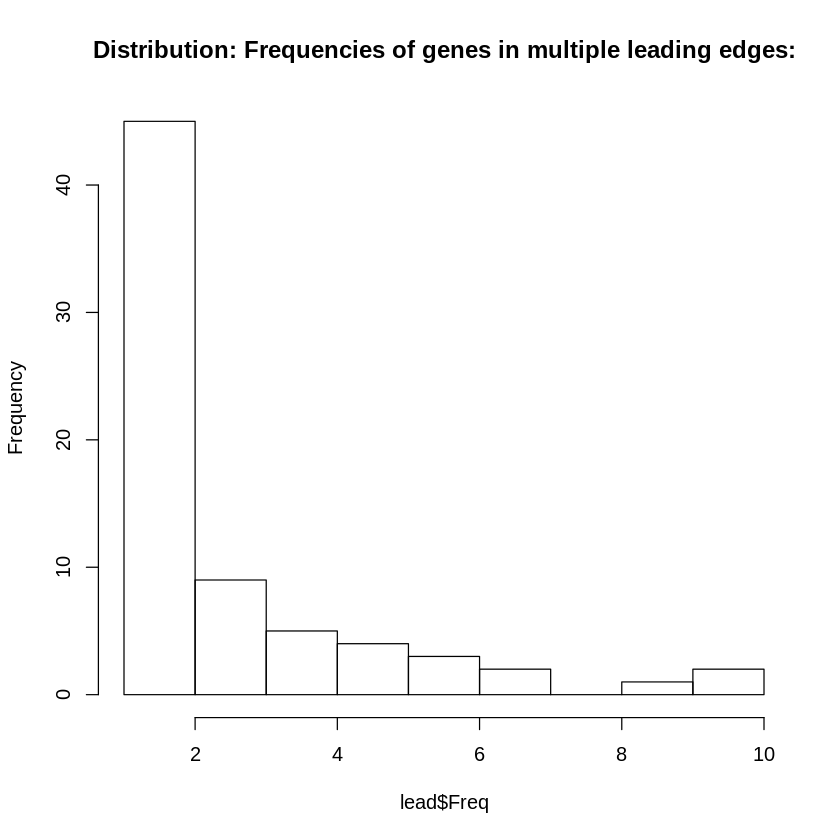

In [0]:
lead <- data.frame(table(unlist( fgsea.res[fgsea.res$pval<0.01, "leadingEdge"])))
hist(lead$Freq, breaks = 10,
      main = "Distribution: Frequencies of genes in multiple leading edges:")

Please note:  
Depending on the R version and fgsea package version, the ranking and therefore also the leading edges might differ slightly.


Let's select the top candidates that appear more than 5 times:

In [0]:
candidates <- as.character(lead[lead$Freq>5, "Var1"])
print(candidates)

[1] "CD226"  "CD274"  "CD28"   "IGHD"   "IL10"   "IL23R"  "RGCC"   "TNFSF4"


## Run trans eQTL analysis

Let's run a trans eQTL analysis for those eight genes and the 109 AF GWAS SNPs:


In [0]:
eQTL <- NULL
try({
  eQTL <- trans.qtl(prefix = "/tmp/example",
                    genotype_file_name = "https://github.com/heiniglab/symatrial/raw/master/example_data/1k_genomes_AF_snps.txt",
                    expression_file_name = t(df[, candidates]),
                    covariates_file_name = df$sex,
                    threshold = 1,
                    compute.all = T,
                    min.pv.by.genesnp = T,
                    save.memory = F,
                    load.qtls = T)
})
if(is.null(eQTL)){
  print("Libraries 'MatrixEQTL' and 'eQTLpipeline' not available. Let's load the results...")
  download.file("https://github.com/heiniglab/symatrial/raw/master/example_data/1k_genomes_trans_eQTLs.RDS",
                dest = "1k_genomes_trans_eQTLs.RDS")
  eQTL <- readRDS("1k_genomes_trans_eQTLs.RDS")
  print("... eQTL results loaded.")
}

Created expression file from matrix for  8  genes by  272  individuals at:
 /tmp/example_gene.txt 
Created covariate file for a single gene for 272 individuals at:
 /tmp/example_covariate.txt 


Rows read: 109 done.

Rows read: 8 done.

Rows read: 1 done.

Processing covariates

Task finished in 0.004 seconds

Processing gene expression data (imputation, residualization)

Task finished in 0.013 seconds

Creating output file(s)

Task finished in 0.017 seconds

Performing eQTL analysis

100.00% done, 872 eQTLs

Task finished in 0.029 seconds





Analysis of  872 QTLs done in:  0.049  seconds 
Detected eQTLs:  872 


Top trans eQTLs:

In [0]:
head(eQTL$all$eqtls[order(eQTL$all$eqtls$pvalue), ])

,snps,gene,statistic,pvalue,FDR,beta
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,rs17079881,IL10,-3.903975,0.0001196941,0.1043733,-0.2317193
2,rs77020228,IGHD,-3.591708,0.0003904660,0.1415209,-0.2915202
3,rs332388,CD28,-3.522075,0.0005028552,0.1415209,-0.2564119
4,rs1044258,IL10,3.450644,0.0006491785,0.1415209,0.1561586
5,rs7526131,RGCC,3.312348,0.0010519059,0.1834524,0.1290141
6,rs17677363,IGHD,3.224628,0.0014171063,0.2059528,0.3377210
